In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import pubchempy as pcp
from matplotlib import pyplot as plt
import torch

Read data

In [2]:
genetic_features = pd.read_csv('data/Cell_Line_Features_PANCAN_simple_MOBEM.tsv', delimiter='\t',index_col=None)
COSMIC_CancerType = pd.read_csv('data/Cell_Lines_Details.csv')
DrugID_Synonyms_TargetPathway = pd.read_csv('data/Drug_Features.csv')
COSMICID_DrugID_CCL = pd.read_csv('data/filteredResponses.csv')

In [3]:
vioxx = c = pcp.Compound.from_cid(479503)
print(vioxx.molecular_formula)
print(vioxx.molecular_weight)
print(vioxx.xlogp)

C16H16O5
288.29
3


rename columns with naming inconsistency

In [4]:
# COSMIC_CancerType.columns
COSMIC_CancerType.rename(columns={'COSMIC identifier': 'COSMIC_ID'}, inplace=True)
DrugID_Synonyms_TargetPathway.rename(columns={'Drug ID': 'DRUG_ID'}, inplace=True)
genetic_features_T=genetic_features.transpose()
genetic_features_T.to_csv('data/genetic_features_T.csv', index=True)
genetic_features_T= pd.read_csv('data/genetic_features_T.csv', skiprows=1)
genetic_features_T.rename(columns={"Unnamed: 0": 'COSMIC_ID'}, inplace=True)
genetic_features_T

,COSMIC_ID,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,1287381,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,924100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,910924,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,687561,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1287706,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,909701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,753620,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,905965,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999,1299061,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Merge data to the CCL table, dropped if no matching drug/cosmic id

In [5]:
COSMICID_DrugID_CCL_CancerType = pd.merge(COSMICID_DrugID_CCL, COSMIC_CancerType, on='COSMIC_ID')
COSMICID_DrugID_CCL_CancerType_Synonyms_TargetPathway = pd.merge(COSMICID_DrugID_CCL_CancerType, DrugID_Synonyms_TargetPathway, on='DRUG_ID')
# COSMICID_DrugID_CCL_CancerType_Synonyms_TargetPathway.columns

In [6]:
All_data=pd.merge(COSMICID_DrugID_CCL_CancerType_Synonyms_TargetPathway, genetic_features_T, on='COSMIC_ID')
All_data.to_csv('data/All_data.csv', index=True)

In [7]:
All_data = pd.read_csv('data/All_data.csv')
print(All_data.columns[20:40])

Index(['norm_cells_4', 'norm_cells_5', 'norm_cells_6', 'norm_cells_7',
       'norm_cells_8', 'norm_cells_9', 'Sample Name',
       'Whole Exome Sequencing (WES)', 'Copy Number Alterations (CNA)',
       'Gene Expression', 'Methylation', 'Drug\rResponse',
       'GDSC\rTissue descriptor 1', 'GDSC\rTissue\rdescriptor 2',
       'Cancer Type\r(matching TCGA label)',
       'Microsatellite \rinstability Status (MSI)', 'Screen Medium',
       'Growth Properties', 'Drug Name', 'Synonyms'],
      dtype='object')


In [8]:


# 统计每个组合的出现次数
col1='DRUG_ID'
col2='Cancer Type\r(matching TCGA label)'
combination_counts = All_data.groupby([col1, col2]).size().reset_index(name='counts')

# 找到出现次数最多的组合
max_count = combination_counts['counts'].max()

# 找到所有出现次数最多的组合
max_combinations = combination_counts[combination_counts['counts'] == max_count]

# 使用这些组合过滤原数据
mask = All_data[[col1, col2]].apply(tuple, axis=1).isin(max_combinations[[col1, col2]].apply(tuple, axis=1))

toy_dataset = All_data[mask]



In [9]:
Shikonin_subset= All_data[All_data['DRUG_ID'] == 170]
Shikonin_subset.to_csv('data/Shikonin_subset.csv', index=True)
CAY10603_subset= All_data[All_data['DRUG_ID'] == 276]
CAY10603_subset.to_csv('data/CAY10603_subset.csv', index=True)
toy_dataset.to_csv('data/toy_dataset.csv', index=True)

In [10]:
def train_val_test_split(dataframe,train_size=0.8,test_size=0.1,random_seed=42):
    train_val_df, test_df = train_test_split(dataframe, test_size=0.1, random_state=random_seed)
    train_df, val_df = train_test_split(train_val_df, test_size=1-train_size/(1-test_size), random_state=random_seed)  
    return train_df,val_df,test_df

def extract_domain_embedding(df):
    domain_dict_collection=[]
    for column in df.select_dtypes(include='object').columns:
        df.loc[df[column] == '', column] = '<empty>'
        labels, unique_values = pd.factorize(df[column])
        labels = labels + 1
        labels[df[column] == '<empty>'] = 0
        df.loc[:, f'encoded_{column}'] = labels
        domain_dict_collection.append(unique_values)
    return df,domain_dict_collection

Shikonin_subset_embedded,dict_list=extract_domain_embedding(Shikonin_subset)
Shikonin_subset_embedded.to_csv('data/Shikonin_subset_embedded.csv', index=True)


toy_dataset_embedded,toy_dict_list=extract_domain_embedding(toy_dataset)

C:\Users\25858\AppData\Local\Temp\ipykernel_329824\4135869109.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'encoded_{column}'] = labels
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\4135869109.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'encoded_{column}'] = labels
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\4135869109.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [11]:

column_types = Shikonin_subset_embedded.dtypes
condition_met = Shikonin_subset_embedded.columns.str.contains('HypMET')
condition_cna = Shikonin_subset_embedded.columns.str.contains('cna')
condition_mut = Shikonin_subset_embedded.columns.str.contains('mut')
# condition_dc = All_datas.columns.str.contains('dc') 

condition_encoded_Cancer_Type = Shikonin_subset_embedded.columns.str.contains('encoded_Cancer Type')

#TODO: find out what is dc
condition_fd_num = Shikonin_subset_embedded.columns.str.contains('fd_num')
condition_MAX_CONC = Shikonin_subset_embedded.columns.str.contains('MAX_CONC')
condition_norm_cells = Shikonin_subset_embedded.columns.str.contains('norm_cells')



In [12]:

conditions=[condition_met,condition_cna,condition_mut,condition_fd_num,condition_MAX_CONC,condition_norm_cells]
masks = [Shikonin_subset_embedded.loc[:, condition] for condition in conditions]

no_intersection = True
for i in range(len(masks)):
    for j in range(i + 1, len(masks)):
        intersection = masks[i].columns.intersection(masks[j].columns)
        if not intersection.empty:
            no_intersection = False
            print(f"Conditions {i+1} and {j+1} have intersection in columns: {list(intersection)}")

if no_intersection:
    print("All conditions are mutually exclusive (no intersection).")
else:
    print("Some conditions have intersections.")

All conditions are mutually exclusive (no intersection).


In [13]:
condition_all_X=condition_met | condition_cna|condition_mut|condition_fd_num|condition_MAX_CONC
condition_all_domain_X=condition_encoded_Cancer_Type
condition_all_y=condition_norm_cells

X_df=Shikonin_subset_embedded.loc[:, condition_all_X]
X_domain_info=Shikonin_subset_embedded.loc[:, condition_all_domain_X]
y_df=Shikonin_subset_embedded.loc[:, condition_all_y]

X_df = X_df.astype({col: 'float64' for col in X_df.columns})
X_domain_info = X_domain_info.astype({col: 'int' for col in X_domain_info.columns})

y_df = y_df.astype({col: 'float64' for col in y_df.columns})

with open('data/full_shots_Shikonin/X_df.pkl', 'wb') as f:
    pickle.dump(X_df, f)
with open('data/full_shots_Shikonin/X_domain_info.pkl', 'wb') as f:
    pickle.dump(X_domain_info, f)
with open('data/full_shots_Shikonin/y_df.pkl', 'wb') as f:
    pickle.dump(y_df, f)



# Generate 2 shot data subset

In [14]:

# 计算每个元素的出现次数
value_counts = X_domain_info['encoded_Cancer Type\r(matching TCGA label)'].value_counts()

# 找出出现次数最多的前两个元素
top_two_elements = value_counts.nlargest(2).index

# 获取这些元素在DataFrame中的所有索引
indexes = X_domain_info[X_domain_info['encoded_Cancer Type\r(matching TCGA label)'].isin(top_two_elements)].index

X_domain_info_2_shots=X_domain_info.loc[indexes]
X_domain_info_2_shots['encoded_Cancer Type\r(matching TCGA label)']=pd.factorize(X_domain_info_2_shots['encoded_Cancer Type\r(matching TCGA label)'])[0]

X_df_2_shots=X_df.loc[indexes]
y_df_2_shots=y_df.loc[indexes]

print(X_domain_info_2_shots.shape)
print(X_df_2_shots.shape)
print(y_df_2_shots.shape)

with open('data/2_shots/X_domain_info.pkl', 'wb') as f:
    pickle.dump(X_domain_info_2_shots, f)
with open('data/2_shots/X_df.pkl', 'wb') as f:
    pickle.dump(X_df_2_shots, f)
with open('data/2_shots/y_df.pkl', 'wb') as f:
    pickle.dump(y_df_2_shots, f)


(62, 1)
(62, 1084)
(62, 10)


# Generate 8 shot data subset

In [15]:

# 计算每个元素的出现次数
value_counts = X_domain_info['encoded_Cancer Type\r(matching TCGA label)'].value_counts()

# 找出出现次数最多的前两个元素
top_two_elements = value_counts.nlargest(8).index

# 获取这些元素在DataFrame中的所有索引
indexes = X_domain_info[X_domain_info['encoded_Cancer Type\r(matching TCGA label)'].isin(top_two_elements)].index

X_domain_info_8_shots=X_domain_info.loc[indexes]
X_domain_info_8_shots['encoded_Cancer Type\r(matching TCGA label)']=pd.factorize(X_domain_info_8_shots['encoded_Cancer Type\r(matching TCGA label)'])[0]


X_df_8_shots=X_df.loc[indexes]
y_df_8_shots=y_df.loc[indexes]

print(X_domain_info_8_shots.shape)
print(X_df_8_shots.shape)
print(y_df_8_shots.shape)

with open('data/8_shots/X_domain_info.pkl', 'wb') as f:
    pickle.dump(X_domain_info_8_shots, f)
with open('data/8_shots/X_df.pkl', 'wb') as f:
    pickle.dump(X_df_8_shots, f)
with open('data/8_shots/y_df.pkl', 'wb') as f:
    pickle.dump(y_df_8_shots, f)


(153, 1)
(153, 1084)
(153, 10)


In [16]:
with open('data/8_shots/X_df.pkl', 'rb') as f:
    test = pickle.load(f)

test

,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,fd_num_5,fd_num_6,fd_num_7,fd_num_8,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
9,16.0,0.0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,16.0,0.0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,16.0,0.0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,16.0,0.0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,16.0,0.0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,16.0,0.0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4850,16.0,0.0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4855,16.0,0.0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4874,16.0,0.0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_df_toy=toy_dataset_embedded.loc[:, condition_all_X]
X_domain_info_toy=toy_dataset_embedded.loc[:, condition_all_domain_X]
y_df_toy=toy_dataset_embedded.loc[:, condition_all_y]

X_df_toy = X_df_toy.astype({col: 'float64' for col in X_df_toy.columns})
X_domain_info_toy = X_domain_info_toy.astype({col: 'int' for col in X_domain_info_toy.columns})

y_df_toy = y_df_toy.astype({col: 'float64' for col in y_df_toy.columns})

with open('data/X_df_toy.pkl', 'wb') as f:
    pickle.dump(X_df_toy, f)
with open('data/X_domain_info_toy.pkl', 'wb') as f:
    pickle.dump(X_domain_info_toy, f)
with open('data/y_df_toy.pkl', 'wb') as f:
    pickle.dump(y_df_toy, f)

Fitting parameters: 0.684824073757318 1.014603925633819 -30.903919011891393 0.014036406479906333


C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:16: RuntimeWarning: overflow encountered in exp
  return ( 1/ (L + np.exp(-k*(x-x0))) + d)


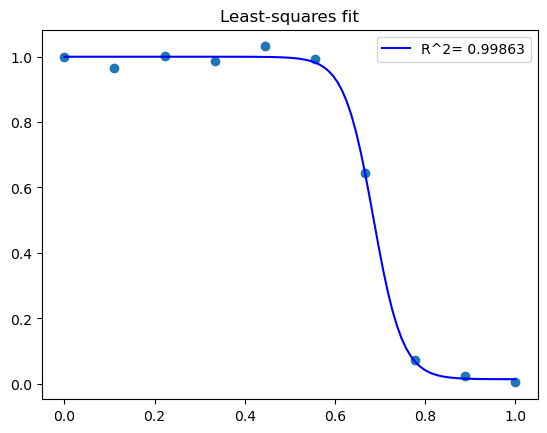

In [18]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
        bounds [0, 1]
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
        L<1 inverted sigmoid, l=100 - lower upper and lower boundso sigmpoid on y axis (y= [0.1, 0.11])
        bounds [0.8, 10]
    k = -1/s (s -shape parameter)  default = -10 k=0 straight line, k<0 sigmoid around k=-10
        bounds [1, -100]
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
         bounds [0, 0.9]
    parameters_bound ((0, 0.8, -100, 0), (1, 10, 1, 0.9))
    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

def FitCurve(fitting_function, x, y, parameters_guess=None, bounds = (-1000, 1000), to_plot = False):
#     from scipy.optimize import curve_fit

    if parameters_guess:
        parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess,maxfev=10000)
    else: 
        parameters, p_covariance = curve_fit(fitting_function, x, y,maxfev=10000)
    x2 = np.linspace(0, 1, 10)
    y_fit = fitting_function(x, *parameters)
    r2 = r2_score(y, y_fit)

    if to_plot:
        print("Fitting parameters:", *parameters)
        plt.scatter(x, y)
        x2 = np.linspace(0, 1, 100)
        y2 = fitting_function(x2, *parameters)
        plt.plot(x2, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend()
    return r2, parameters

x = np.linspace(0,1, 10)
y=[1,0.966554453,1.002028592,0.987976122,1.030967736,0.993374334,0.642977551,0.071645846,0.022449543,0.00407778]
r2,params=FitCurve(sigmoid_4_param,x,y,to_plot=True)


In [19]:
data = {
    'x0': [],
    'L': [],
    'k':[],
    'd':[],
    'r2':[]
}
df = pd.DataFrame(data)
# 使用 iterrows() 迭代每一行
x = np.linspace(0,1, 10)
new_rows = []
for index, row in y_df_2_shots.iterrows():
    # print(f"Index: {index}")
    # print(row.values)
    r2,params=FitCurve(sigmoid_4_param,x,row.values)
    new_row={
    'x0': params[0],
    'L': params[1],
    'k':params[2],
    'd':params[3],
    'r2':r2
    }
    new_rows.append(new_row)
    # print(f"params:{params};r2:{r2}")
y_df_2_shots_4_params_sigmoid=pd.DataFrame(new_rows)
indice=y_df_2_shots_4_params_sigmoid['r2'] > 0.80

C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, p_covariance = curve_fit(fitting_function, x, y,maxfev=10000)
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:16: RuntimeWarning: overflow encountered in exp
  return ( 1/ (L + np.exp(-k*(x-x0))) + d)
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:16: RuntimeWarning: overflow encountered in exp
  return ( 1/ (L + np.exp(-k*(x-x0))) + d)
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, p_covariance = curve_fit(fitting_function, x, y,maxfev=10000)
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, p_covariance = curve_fit(fitting_function, x, y,maxfev=10000)
C:\Users\25858\AppData\Local\Temp\ipykernel_32

In [20]:
y_df_2_shots_4_params_sigmoid=y_df_2_shots_4_params_sigmoid.reset_index(drop=True)
X_df_2_shots=X_df_2_shots.reset_index(drop=True)
X_domain_info_2_shots=X_domain_info_2_shots.reset_index(drop=True)
filtered_df = y_df_2_shots_4_params_sigmoid[y_df_2_shots_4_params_sigmoid['r2'] >0.80]

# 获取这些行的索引
indice = filtered_df.index
y_df_2_shots_4_params_sigmoid=y_df_2_shots_4_params_sigmoid.loc[indice].iloc[:, :4]
X_df_2_shots_4_params_sigmoid=X_df_2_shots.loc[indice]
X_domain_info_2_shots_4_params_sigmoid=X_domain_info_2_shots.loc[indice]

with open('data/2_shots_4_params_sigmoid/X_df.pkl', 'wb') as f:
    pickle.dump(X_df_2_shots_4_params_sigmoid, f)
with open('data/2_shots_4_params_sigmoid/X_domain_info.pkl', 'wb') as f:
    pickle.dump(X_domain_info_2_shots_4_params_sigmoid, f)
with open('data/2_shots_4_params_sigmoid/y_df.pkl', 'wb') as f:
    pickle.dump(y_df_2_shots_4_params_sigmoid, f)

In [21]:
data = {
    'x0': [],
    'L': [],
    'k':[],
    'd':[],
    'r2':[]
}
df = pd.DataFrame(data)
# 使用 iterrows() 迭代每一行
x = np.linspace(0,1, 10)
new_rows = []
for index, row in y_df.iterrows():
    # print(f"Index: {index}")
    # print(row.values)
    r2,params=FitCurve(sigmoid_4_param,x,row.values)
    new_row={
    'x0': params[0],
    'L': params[1],
    'k':params[2],
    'd':params[3],
    'r2':r2
    }
    new_rows.append(new_row)
    # print(f"params:{params};r2:{r2}")
y_df_4_params_sigmoid=pd.DataFrame(new_rows)
indice=y_df_4_params_sigmoid['r2'] > 0.80

C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:16: RuntimeWarning: overflow encountered in exp
  return ( 1/ (L + np.exp(-k*(x-x0))) + d)
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:16: RuntimeWarning: overflow encountered in exp
  return ( 1/ (L + np.exp(-k*(x-x0))) + d)
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, p_covariance = curve_fit(fitting_function, x, y,maxfev=10000)
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:16: RuntimeWarning: overflow encountered in exp
  return ( 1/ (L + np.exp(-k*(x-x0))) + d)
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, p_covariance = curve_fit(fitting_function, x, y,maxfev=10000)
C:\Users\25858\AppData\Local\Temp\ipykernel_329824\3119618030.py:16: RuntimeWarning: overflow encountere

In [22]:
y_df_4_params_sigmoid=y_df_4_params_sigmoid.reset_index()
X_df=X_df.reset_index()
y_df=y_df.reset_index()
X_domain_info=X_domain_info.reset_index(drop=True)
filtered_df = y_df_4_params_sigmoid[y_df_4_params_sigmoid['r2'] >0.90]

# 获取这些行的索引
indice = filtered_df.index
y_df_4_params_sigmoid=y_df.loc[indice].iloc[:, :4]
X_df_4_params_sigmoid=X_df.loc[indice]
X_domain_infos_4_params_sigmoid=X_domain_info.loc[indice]

with open('data/4_params_sigmoid/X_df.pkl', 'wb') as f:
    pickle.dump(X_df_4_params_sigmoid, f)
with open('data/4_params_sigmoid/X_domain_info.pkl', 'wb') as f:
    pickle.dump(X_domain_infos_4_params_sigmoid, f)
with open('data/4_params_sigmoid/y_df.pkl', 'wb') as f:
    pickle.dump(y_df_4_params_sigmoid, f)

In [23]:
# X_path="data/X_df_toy.pkl"
# y_path="data/y_df_toy.pkl"

# X_path="data/X_df_Shikonin.pkl"
# y_path="data/y_df_Shikonin.pkl"
# X_domain_path="data/X_domain_info_Shikonin.pkl"

con=config()

X_path="data/X_df_2_shots.pkl"
y_path="data/y_df_2_shots.pkl"
X_domain_path="data/X_domain_info_2_shots.pkl"

# X_path="data/2_shots_4_params_sigmoid/X_df.pkl"
# y_path="data/2_shots_4_params_sigmoid/y_df.pkl"
# X_domain_path="data/2_shots_4_params_sigmoid/X_domain_info.pkl"
(X_train_tensor,X_D_train_tensor,y_train_tensor),(X_test_tensor,X_D_test_tensor,y_test_tensor)=load_dataset(X_path,y_path,do_standardisation=True,X_domain_path=X_domain_path)

print(X_train_tensor.shape)
print(X_D_train_tensor.shape)
print(y_train_tensor.shape)

con.NUM_CONC=y_train_tensor.shape[1]

con.NUM_FEAT=X_train_tensor.shape[1]
con.NUM_DOMAIN_FEAT=X_D_train_tensor.shape[1]
NUMS_DOMAIN, max_indices_row = torch.max(X_D_train_tensor, dim=0)
NUMS_DOMAIN.add_(1)


print(NUMS_DOMAIN.item())
con.NUMS_DOMAIN=NUMS_DOMAIN.long()
X_train_tensor = torch.cat((X_D_train_tensor, X_train_tensor), dim=1)
X_test_tensor = torch.cat((X_D_test_tensor, X_test_tensor), dim=1)
print(X_train_tensor.shape)
print(X_test_tensor.shape)

with open(X_path, 'rb') as f:
    X_df = pickle.load(f)
mask_bool_met = X_df.columns.str.contains("HypMET")
mask_bool_mut = X_df.columns.str.contains("mut")
mask_bool_cna = X_df.columns.str.contains("cna")
mask_bool_dc  = X_df.columns.str.contains("dc")

mask_float_met = np.array(mask_bool_met, dtype=np.float32) 
mask_float_mut = np.array(mask_bool_mut, dtype=np.float32)
mask_float_cna = np.array(mask_bool_cna, dtype=np.float32)
mask_float_dc  = np.array(mask_bool_dc, dtype=np.float32)

diag_matrix_met = torch.tensor(np.diag(mask_float_met))
diag_matrix_mut = torch.tensor(np.diag(mask_float_mut))
diag_matrix_cna = torch.tensor(np.diag(mask_float_cna))
diag_matrix_dc  = torch.tensor(np.diag(mask_float_dc))
filters=(diag_matrix_mut,diag_matrix_met,diag_matrix_cna,diag_matrix_dc)
print("MUT features:"+str(np.sum(mask_float_mut))+str(diag_matrix_met.shape))
print("Met features:"+str(np.sum(mask_float_met))+str(diag_matrix_met.shape))
print("CNA features:"+str(np.sum(mask_float_cna))+str(diag_matrix_met.shape))
print("DC features:"+str(np.sum(mask_float_dc))+str(diag_matrix_met.shape))  

NameError: name 'config' is not defined